## import

In [1]:
import re
import os
import gc
import yaml
import argparse
from string import punctuation

# https://github.com/matplotlib/matplotlib/issues/25506
# import maplitlib Before import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from matplotlib.patches import Rectangle

import librosa
import librosa.display
import IPython.display as ipd

from pathlib import Path
from PIL import Image

import torch
import yaml
import numpy as np
from torch.utils.data import DataLoader
from g2p_en import G2p
# from pypinyin import pinyin, Style

from utils.tools import * ## NOT GPU
from utils.model import * ## NOT GPU
from dataset import TextDataset
from text import text_to_sequence

os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Configs

In [2]:
preprocess_config = yaml.load(open("./config/LJSpeech/preprocess.yaml", "r"), Loader=yaml.FullLoader)
train_config = yaml.load(open("./config/LJSpeech/train.yaml", "r"), Loader=yaml.FullLoader)
model_config = yaml.load(open("./config/LJSpeech/model.yaml", "r"), Loader=yaml.FullLoader)

configs = (preprocess_config, model_config, train_config) 
print("Configs Done")

Configs Done


## Sample

In [3]:
text =  "Hello, My name is John Wick and I am a professional killer."

In [4]:
def read_lexicon(lex_path):
    lexicon = {}
    with open(lex_path) as f:
        for line in f:
            temp = re.split(r"\s+", line.strip("\n"))
            word = temp[0]
            phones = temp[1:]
            if word.lower() not in lexicon:
                lexicon[word.lower()] = phones
    return lexicon


def preprocess_english(text,
                       preprocess_config = yaml.load(open("./config/LJSpeech/preprocess.yaml", "r"), Loader=yaml.FullLoader)
                       ):
    text = text.rstrip(punctuation)
    lexicon = read_lexicon(preprocess_config["path"]["lexicon_path"])

    g2p = G2p()
    phones = []
    words = re.split(r"([,;.\-\?\!\s+])", text)
    for w in words:
        if w.lower() in lexicon:
            phones += lexicon[w.lower()]
        else:
            phones += list(filter(lambda p: p != " ", g2p(w)))
    phones = "{" + "}{".join(phones) + "}"
    phones = re.sub(r"\{[^\w\s]?\}", "{sp}", phones)
    phones = phones.replace("}{", " ")

    print("Raw Text Sequence: {}".format(text))
    print("Phoneme Sequence: {}".format(phones))
    sequence = np.array(
        text_to_sequence(
            phones, preprocess_config["preprocessing"]["text"]["text_cleaners"]
        )
    )

    return np.array(sequence), phones

In [5]:
sequence, phones = preprocess_english(text, preprocess_config)
print(sequence.shape)
print(sequence[:5])
print(phones)

Raw Text Sequence: Hello, My name is John Wick and I am a professional killer
Phoneme Sequence: {HH AH0 L OW1 sp M AY1 N EY1 M IH0 Z JH AA1 N W IH1 K AE1 N D AY1 AE1 M AH0 P R AH0 F EH1 SH AH0 N AH0 L K IH1 L ER0}
(39,)
[106  73 117 123 357]
{HH AH0 L OW1 sp M AY1 N EY1 M IH0 Z JH AA1 N W IH1 K AE1 N D AY1 AE1 M AH0 P R AH0 F EH1 SH AH0 N AH0 L K IH1 L ER0}


## Device

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## `get_model`

## Model and Vocoder

In [7]:
class sample_args:
    restore_step = 100000 # 84160

model_id= sample_args.restore_step,
print(model_id, sample_args.restore_step, sample_args)

# Getting Model
model= get_model(sample_args, configs, device = device, train=False)
print("Model Loaded")

(100000,) 100000 <class '__main__.sample_args'>
Model Loaded


## conver_to_inputs

In [8]:
def convert_to_inputs(raw_texts,
                      preprocess_config = yaml.load(open("./config/LJSpeech/preprocess.yaml", "r"), Loader=yaml.FullLoader)
                      ):

    # 1) Speaker_id
    speakers = np.array([13099]) # speaker: 100

    # 2) G2P
    sequence, phones = preprocess_english(raw_texts, preprocess_config)
    print("Sequence: ",sequence)
    print("Phones: ", phones)
    print(sequence.shape)
    texts = sequence.reshape(1, -1)
    print(texts.shape)
    print(texts)
    print()

    text_lens = np.array([len(texts[0])])
    print(text_lens)
    print()
    
    ids = raw_texts[0]
    batchs = [(ids, raw_texts, speakers, texts, text_lens, max(text_lens))]
    return batchs, phones

## `Synthesize_fn`

In [9]:
@torch.inference_mode()
def synthesize_fn(model, 
                  # step, # sample_args.restore_step, 
                  configs, # configs = (preprocess_config, model_config, train_config) 
                  batchs, 
                  control_values, 
                  device, 
                  vocoder, 
                  vocoder_train_setup=None,
                  denoiser = None, 
                  denoising_strength=0.005
                  ):
    
    preprocess_config, model_config, train_config = configs
    pitch_control, energy_control, duration_control = control_values

    model.eval()
    with torch.no_grad():
        for batch in batchs:
            cuda_batch = to_device(batch, device)
            # Forward
            output = model(*(cuda_batch[2:]), 
                            p_control=pitch_control, 
                            e_control=energy_control, 
                            d_control=duration_control
                            )
            
            # Synthesize
            synth_samples(cuda_batch, 
                          output, 
                          model_config, 
                          preprocess_config, 
                          train_config["path"]["result_path"],
                          vocoder, 
                          vocoder_train_setup, 
                          denoiser, 
                          denoising_strength
                          )
            

## syn

In [10]:
# To Device
def syn(raw_texts, 
        model,
        configs, 
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), 
        control_values = (1.0, 1.0, 1.0)
        ):

    # Configs
    preprocess_config, model_config, train_config = configs 

    # Load vocoder
    vocoder, vocoder_train_setup, denoiser = get_vocoder(model_config, device)
    
    # control_values = args.pitch_control, args.energy_control, args.duration_control
    control_values = control_values 
    print(f"Vocoder Downloaded")
    print(f"CONTROL VALUES: {control_values}")

    # device
    model = model.to(device)
    denoiser = denoiser.to(device)
    vocoder = vocoder.to(device)
    print("Accelerate Prepared:")
    
    # Convert
    batchs, phones = convert_to_inputs(raw_texts, preprocess_config)
    ids = batchs[0][0]
    
    # Synthesize
    synthesize_fn(model, 
                  # step, # sample_args.restore_step, 
                  configs, # configs = (preprocess_config, model_config, train_config) 
                  batchs, 
                  control_values, 
                  device, 
                  vocoder, 
                  vocoder_train_setup, 
                  denoiser, 
                  0.0025
                  )
    print("synthesized")

    # Saved Paths: AUDIO, MEL SAVE PATH
    audio_result_path = train_config["path"]["result_path"] + f"/{ids}.wav"
    mel_result_path = train_config["path"]["result_path"] + f"/{ids}.png"
    
    # [Errno 2] No such file or directory: 'home/heiscold/fastspeech2/result/ljspeech/t_01/H.png'
    # /home/heiscold/fastspeech2/result/ljspeech/t_01

    return ids, raw_texts, phones, audio_result_path, mel_result_path 

## My name is Ro Hoon and I am researching text-to-speech in my lab

In [19]:
raw_texts =  "My name is Ro Hoon and I am researching text-to-speech in my lab."
ids, raw_texts, phones, audio_result_path, mel_result_path = syn(raw_texts, 
                                                                 model = model,
                                                                 configs= configs, 
                                                                 device = device, 
                                                                 control_values = (1.0, 1.0, 1.0 ) )

Using cache found in /home/heiscold/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/heiscold/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/heiscold/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


HiFi-GAN: Removing weight norm.
DownLoaded | NVIDIA's HiFi-GAN from torch hub | SR: 22050
Vocoder Downloaded
CONTROL VALUES: (1.0, 1.0, 1.0)
Accelerate Prepared:
Raw Text Sequence: My name is Ro Hoon and I am researching text-to-speech in my lab
Phoneme Sequence: {M AY1 N EY1 M IH0 Z R OW1 HH UW1 N AE1 N D AY1 AE1 M R IY0 S ER1 CH IH0 NG T EH1 K S T sp T AH0 sp S P IY1 CH IH0 N M AY1 L AE1 B}
Sequence:  [118  86 119 102 118 108 146 130 123 106 141 119  70 119  90  86  70 118
 130 112 131  98  89 108 120 133  94 116 131 133 357 133  73 357 131 129
 113  89 108 119 118  86 117  70  88]
Phones:  {M AY1 N EY1 M IH0 Z R OW1 HH UW1 N AE1 N D AY1 AE1 M R IY0 S ER1 CH IH0 NG T EH1 K S T sp T AH0 sp S P IY1 CH IH0 N M AY1 L AE1 B}
(45,)
(1, 45)
[[118  86 119 102 118 108 146 130 123 106 141 119  70 119  90  86  70 118
  130 112 131  98  89 108 120 133  94 116 131 133 357 133  73 357 131 129
  113  89 108 119 118  86 117  70  88]]

[45]

synthesized


MODEL ID: (100000,)
SENTENCE: My name is Ro Hoon and I am researching text-to-speech in my lab.
Pure Length 65
Phones: {M AY1 N EY1 M IH0 Z R OW1 HH UW1 N AE1 N D AY1 AE1 M R IY0 S ER1 CH IH0 NG T EH1 K S T sp T AH0 sp S P IY1 CH IH0 N M AY1 L AE1 B}
/home/heiscold/fastspeech2/result/ljspeech/t_01/M.wav


/home/heiscold/fastspeech2/result/ljspeech/t_01/M.png


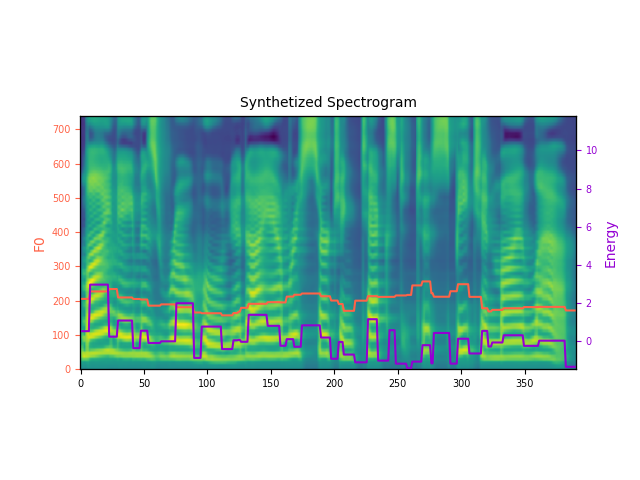

In [20]:
print(f"MODEL ID: {model_id}")
print(f"SENTENCE: {raw_texts}")
print(f"Pure Length {len(raw_texts)}")
print(f"Phones: {phones}")
sample_rate = 22050
## This is Predicted Speech
print(audio_result_path)
ipd.display(ipd.Audio(audio_result_path, rate =sample_rate)) 
# wav, sr = librosa.load(audio_result_path, sr=None)
# wav = librosa.resample(wav, orig_sr=sr, target_sr=sample_rate)
# print(f"{sample_rate} -> {sr}")
# ipd.display(ipd.Audio(wav, rate =sample_rate)) 

print(mel_result_path)
Image.open(mel_result_path).convert("RGB")